# Прикладные задачи анализа данных. Семинар 4. Normalizing Flows.

[Link to Colab](https://colab.research.google.com/drive/104HFNgITGwBpmF9gv23DGJuPCjWwrmwS?usp=sharing)

## 1. Normalizing Flows.

Normalizing Flows (нормпотоки) - генеративные модели, построенные на объединении биективных (обратимых) функций. 

Процесс генерации в нормпотоках выглядит так: семплируется объект из априорного распределения (как и в случае с VAE и GAN, обычно, это стандартное нормальное распределение) и друг за другом прогоняется через биективные слои. На выходе из нормпотока мы ожидаем получить объект из распределения на данных.

В процессе обучения мы делаем противоположное - берем объект из данных и прогоняем его через норм поток по направлению к априорному распределению, применяя обратные функции.

![Normalizing flows](https://raw.githubusercontent.com/janosh/awesome-normalizing-flows/75108d9d3a41bd5af94d8cd252358979f800ec47/assets/normalizing-flow.svg)

Image credits: [github, awesome-normalizing-flows](https://github.com/janosh/awesome-normalizing-flows)


Обучение нормпотоков происходит путем максимизации логарифма правдоподобия объектов (maximum likelihood principle), который вычисляется через **change of variables formula**:

$$\log p(x) = \log p_{prior}(x_{k}) + \sum_{i} \log \Big| \det \Big(\frac{\delta f(x_i)}{x_i} \Big) \Big| $$ 

In [1]:
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

device = 'cuda:0'
torch.cuda.set_device(0)

Абстрактные классы для блока нормпотока `InvertibleLayer` и для всего нормпотока `NormalizingFlow` можно определить следующим образом.

У блока `InvertibleLayer` должны быть определены две функции:

* `def f(self, x)`, которая делает прямое преобразование и возращает два значения: $f(x)$ и $ \log \big| \det \big(\frac{\delta f(x)}{x} \big) \big|$
* `def g(self, x)`, которая делает обратное преобразование и возвращает одно значение: $f^{-1}(x)$

Чтобы проверить, что ваш код написан правильно, используйте функции `check_inverse` и `check_log_det` для проверки обратимости слоя и для проверки правильности подсчета $ \log \big| \det \big(\frac{\delta f(x)}{x} \big) \big|$

In [2]:
class InvertibleLayer(nn.Module):
  def __init__(self, var_size):
    super(InvertibleLayer, self).__init__()

    self.var_size = var_size

  def f(self, x):
    '''
    Implementation of forward pass.
    
    x: torch.Tensor of shape [batch_size, var_size]

    Return:
      torch.Tensor of shape [batch_size, var_size], torch.Tensor of shape [batch_size]
    '''
    pass

  def g(self, x):
    '''
    Implementation of backward (inverse) pass.

    x: torch.Tensor of shape [batch_size, var_size]
    
    Return:
    А  torch.Tensor of shape [batch_size, var_size]
    '''
    pass

  def check_inverse(self):
    '''
    Perform check of invertibility.
    '''
    x = torch.randn(10, self.var_size)

    assert torch.norm(x - self.g(self.f(x)[0])).item() < 0.001

  def check_log_det(self):
    '''
    Perform check of log determinant.
    '''
    x = torch.randn(1, self.var_size).requires_grad_()
    _, log_det = self.f(x)

    jac = torch.autograd.functional.jacobian(lambda x: self.f(x)[0], x)
    assert torch.abs(log_det - torch.log(torch.det(jac[0, :, 0, :]))).item() < 0.001

Класс `NormalizingFlow` инициализируется списком обратимых слоев и нормальным прайором. А так же реализует функции `log_prob` для подсчета логарифма правдоподобия объектов и `sample` для семплирования объектов.

In [4]:
class NormalizingFlow(nn.Module):
  def __init__(self, layers, prior):
    super(NormalizingFlow, self).__init__()

    self.layers = nn.ModuleList(layers)
    self.prior = prior

  def log_prob(self, x):
    log_likelihood = None

    for layer in self.layers:
      x, change = layer.f(x)
      if log_likelihood is not None:
        log_likelihood = log_likelihood + change
      else:
        log_likelihood = change
    log_likelihood = log_likelihood + self.prior.log_prob(x)

    return log_likelihood.mean()

  def sample(self, num_samples):
    x = self.prior.sample((num_samples, ))

    for layer in self.layers[::-1]:
      x = layer.g(x)

    return x

Как и говорилось ранее, обучение нормпотока происходит путем максимизации правдоподобия объектов.

Важный момент - если вы работаете с дискретными данными (например с MNIST, у которого пиксели либо 0, либо 1), не забывайте делать *деквантизацию* - прибавление мелкого шума к объекту. Это необходимо для предотвращение численных неустойчивостей при обучение.

In [5]:
def train_nf(tr_dataloader,
             nf, opt,
             num_epochs, 
             verbose_num_iters=100,
             data_type='2d'):
    nf.train()
    loss_trace = []
    
    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # берем объекты
            x, _ = batch
            x = x.to(device)

            if data_type == 'mnist':
              x = x.view(x.shape[0], -1)
              # деквантизация
              x = x + 0.05 * torch.randn_like(x)


            # делаем шаг обучения
            opt.zero_grad()
            loss = -nf.log_prob(x)
            loss.backward()
            opt.step()
            loss_trace.append((iter_i, loss.item()))

            iter_i += 1

            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Normalizing flow loss')
                plt.plot([p[0] for p in loss_trace], 
                         [p[1] for p in loss_trace])
                    
                nf.eval()
                if data_type == '2d':
                  plt.subplot(1, 2, 2)
                  with torch.no_grad():
                    sampled_2d = nf.sample(1024)
                  plt.xlim(-2, 2)
                  plt.ylim(-2, 2)
                  plt.scatter(
                    sampled_2d[:, 0].cpu().detach().numpy(),
                    sampled_2d[:, 1].cpu().detach().numpy(),
                    s=1)
                elif data_type == 'mnist':
                  with torch.no_grad():
                    sampled_mnist = torch.clamp(nf.sample(100), min=-1., max=1.)

                  for i in range(100):
                    plt.subplot(10, 20, 20 * (i // 10) + 11 + (i % 10))
                    plt.axis('off')
                    plt.imshow(sampled_mnist[i].view(16, 16).detach().cpu().numpy(), cmap='gray')

                plt.show()
                nf.train()
                
    nf.eval()

## 2. Toy problem.

Для начала, чтобы познакомиться с нормпотоками и написать простой норм поток, давайте попробуем смоделировать вот такое многомодальное распределение.



In [6]:
class Dataset2d:
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.x.shape[0]

In [7]:
import numpy as np

total_size = 10000

scale = 1.
centers = [(x, y) for x in [-1, 1] for y in [-1, 1]]
centers = [(scale * x, scale * y) for x, y in centers]

dataset = []

rng = np.random.RandomState()

for i in range(total_size):
    point = (rng.rand(2) - 0.5) * 0.5
    idx = rng.randint(len(centers))
    center = centers[idx]
    point[0] += center[0]
    point[1] += center[1]
    dataset.append(point)
x = np.array(dataset, dtype="float32")
x /= 1.414

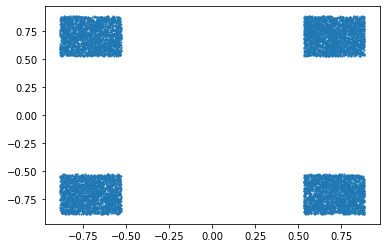

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x[:, 0], x[:, 1], s=1)

In [9]:
trainset = Dataset2d(x, torch.zeros(x.shape[0]))
trainloader_2d = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Для моделирования предлагается использовать следующие преобразования:

1. ActNorm - произоводим обратимый сдвиг на $b$ и растяжение пространства на $w$. 

$$f_{w, b}(x) = w \odot x + b ;\\ 
f^{-1}_{w, b}(x) = (x - b) \oslash w \\
\log \big| \det \big(\frac{\delta f(x)}{\delta x} \big) \big| = \sum_i \log |w_i| $$

2. Монотонная нелинейность, например такая

$$f(x) = \begin{cases}
x \text{ if } |x| > 1; \\
x^3 \text{if} |x| \le 1;
\end{cases} \\
f^{-1}(x) = \begin{cases}
x \text{ if } |x| > 1; \\
x^{1/3} \text{if} |x| \le  1;
\end{cases} \\
\log \big| \det \big(\frac{\delta f(x)}{\delta x} \big) \big| = \sum_i \mathbb{I}[|x| \le  1] \log (3 x^2) $$


In [11]:
class ActNorm(InvertibleLayer):
  def __init__(self, var_size):
    super(ActNorm, self).__init__(var_size=var_size)
    
    # model w as torch.exp(self.log_w)
    self.log_w = nn.Parameter(torch.randn(var_size))
    self.bias = nn.Parameter(torch.zeros(var_size))

    self.initialized = False

  def f(self, x):
    if not self.initialized:
      self.bias.data = -x.mean(dim=0)
      self.log_w.data = -torch.log(x.std(dim=0) + 1e-1)
      self.initialized = True

    new_x = # your code here
    log_det = # your code here
    return new_x, log_det

  def g(self, x):
    return torch.exp(-self.log_w[None, :]) * (x - self.bias)

class InvNonlin(InvertibleLayer):
  def __init__(self, var_size):
    super(InvNonlin, self).__init__(var_size=var_size)

  def f(self, x):
    mask = (torch.abs(x) < 1).float()
    pow = 3 * mask + 1 * (1 - mask)

    signs = torch.sign(x)
    new_x = signs * ((x * signs) ** pow)

    log_det = torch.log((3 * (x**2)) * mask + (1 - mask)).sum(dim=-1)

    return new_x, log_det

  def g(self, x):
    mask = (torch.abs(x) < 1).float()
    pow = (1./3) * mask + 1 * (1 - mask)

    signs = torch.sign(x)
    new_x = signs * ((x * signs) ** pow)

    return new_x

Проверим, что мы правильно реализовали наш код.

In [32]:
layer = ActNorm(var_size=2)
layer.check_inverse()
layer.check_log_det()

layer = InvNonlin(var_size=2)
layer.check_inverse()
layer.check_log_det()

Накидаем несколько обратимых слоев и попробуем обучить.

In [48]:
prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda())

layers = []
for i in range(9):
  if i % 2 == 0:
    layers.append(ActNorm(2))
  else:
    layers.append(InvNonlin(2))

nf = NormalizingFlow(layers=layers,
                     prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

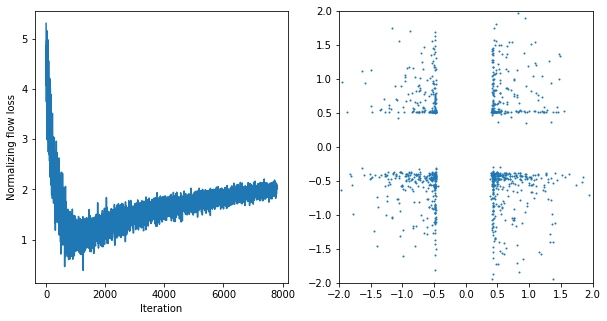

In [49]:
train_nf(trainloader_2d, nf, opt, num_epochs=50, verbose_num_iters=100, data_type='2d')

Написанные нами обратимые преобразования крайне просты и содержат мало обучаемых параметров, однако даже их хватает для разделения нормального распределения на 4 моды.

На практике же чаще используют RealNVP - обратимые слои, параметризуемые нейронками, которые во много раз более гибкие, чем те, что мы реализовали сейчас.

## 3. RealNVP

RealNVP - обратимое преобразование, параметризуемое нейронными сетями $t_{\theta}, s_{\omega}$. Для его работы описание объекта $x$ случайным образом разделяют на две группы $x_a, x_b$ и преобразуют только одну группу $x_b$, опираясь на выходы нейронных сетей для группы $x_a$.

$$
\begin{cases}
f_{\theta, \omega}(x_a) = x_a; \\
f_{\theta, \omega}(x_b) = x_b \odot \exp(s_{\omega}(x_a)) + t_{\theta}(x_a)
\end{cases} \\ 
\begin{cases}
f^{-1}_{\theta, \omega}(x_a) = x_a; \\
f^{-1}_{\theta, \omega}(x_b) = (x_b -  t_{\theta}(x_a)) \odot \exp(-s_{\omega}(x_a))
\end{cases} \\
\log \big| \det \big(\frac{\delta f(x)}{\delta x} \big) \big| = \sum s_{\omega}(x_a)
$$

In [51]:
class RealNVP(InvertibleLayer):
  def __init__(self, var_size, mask, hidden=16):
    super(RealNVP, self).__init__(var_size=var_size)
    
    self.mask = mask

    self.nn_t = nn.Sequential(
        nn.Linear(var_size, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, var_size)
        )
    self.nn_s = nn.Sequential(
        nn.Linear(var_size, hidden),
        nn.ReLU(),
        nn.Linear(hidden, hidden),
        nn.ReLU(),
        nn.Linear(hidden, var_size),
        )

  def f(self, x):
    t = self.nn_t(x * self.mask[None, :])
    s = torch.tanh(self.nn_s(x * self.mask[None, :])) # tanh важен чтобы ограничить scale снизу и сверху

    new_x = (x * torch.exp(s) + t) * (1 - self.mask[None, :]) + x * self.mask[None, :]
    log_det = (s * (1 - self.mask[None, :])).sum(dim=-1)
    return new_x, log_det

  def g(self, x):
    t = self.nn_t(x * self.mask[None, :])
    s = torch.tanh(self.nn_s(x * self.mask[None, :]))

    new_x = ((x - t) * torch.exp(-s)) * (1 - self.mask[None, :]) + x * self.mask[None, :]
    return new_x

In [55]:
# не забываем проверить правильность написанного нами кода
layer = RealNVP(var_size=2, mask=torch.tensor([0, 1]))
layer.check_inverse()
layer.check_log_det()

In [56]:
prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda())

layers = []
for i in range(16):
  layers.append(ActNorm(var_size=2))
  layers.append(RealNVP(var_size=2, mask=((torch.arange(2) + i) % 2).cuda()))

nf = NormalizingFlow(layers=layers,
                    prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

Обучим на том же датасете из четырех мод.

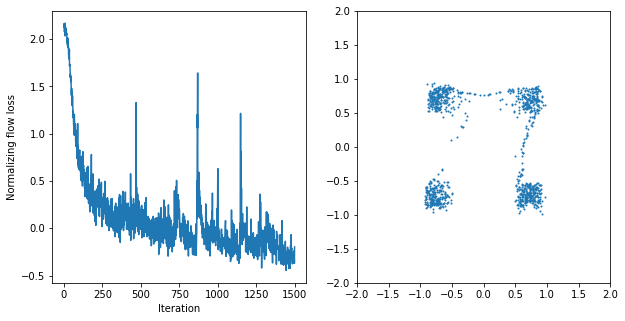

In [57]:
train_nf(trainloader_2d, nf, opt, num_epochs=10, verbose_num_iters=100, data_type='2d')

Получилось! Хоть и остались перешейки, соединяющие моды, однако выученное распределение почти в точности совпадает с распределением над данными.

Теперь попробуем датасет потяжелее.

In [58]:
import sklearn.datasets
data = sklearn.datasets.make_moons(n_samples=10000, noise=0.1)[0]
x = data.astype("float32")

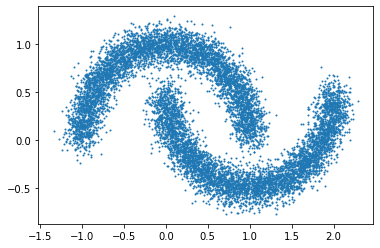

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x[:, 0], x[:, 1], s=1)

In [60]:
trainset = Dataset2d(x, torch.zeros(x.shape[0]))
trainloader_2d = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [61]:
prior = torch.distributions.MultivariateNormal(torch.zeros(2).cuda(), torch.eye(2).cuda())

layers = []
for i in range(8):
  layers.append(ActNorm(var_size=2))
  layers.append(RealNVP(var_size=2, mask=((torch.arange(2) + i) % 2).cuda()))

nf = NormalizingFlow(layers=layers,
                    prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

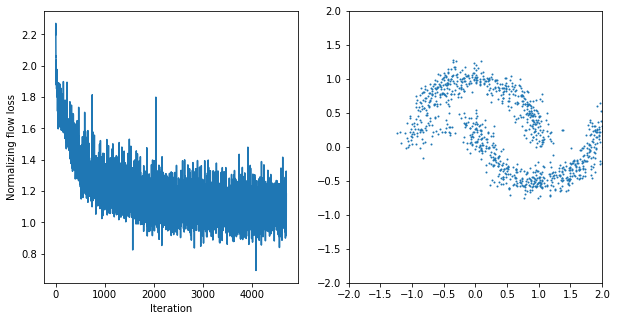

In [62]:
train_nf(trainloader_2d, nf, opt, num_epochs=30, verbose_num_iters=100, data_type='2d')

**Hint**: Иногда у RealNVP не хватает мощности, чтобы выучить какое-то распределение. Ахиллесова пята RealNVP в том, что он обновляет за раз только половину переменных. В случае с 2d данными это может становиться bottleneck'ом.

Для низкоразмерных данных применяют следующий трюк - добавляют к данным несколько фиктивных размерностей, заполненных шумом.

In [63]:
total_size = 10000
x1 = np.random.rand(total_size) * 4 - 2
x2_ = np.random.rand(total_size) - np.random.randint(0, 2, total_size) * 2
x2 = x2_ + (np.floor(x1) % 2)
data = np.concatenate([x1[:, None], x2[:, None]], 1)
x = np.array(data, dtype="float32")

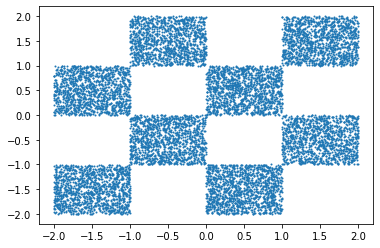

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(x[:, 0], x[:, 1], s=1)

In [65]:
x_4d = np.concatenate([x, np.random.randn(x.shape[0], 2)], axis=1).astype(np.float32)

trainset = Dataset2d(x_4d, torch.zeros(x_4d.shape[0]))
trainloader_4d = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

In [66]:
prior = torch.distributions.MultivariateNormal(torch.zeros(4).cuda(), torch.eye(4).cuda())

layers = []
for i in range(16):
  layers.append(ActNorm(var_size=4))
  layers.append(RealNVP(var_size=4, mask=((torch.arange(4) + i) % 2).cuda()))

nf = NormalizingFlow(layers=layers,
                    prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=1e-3)

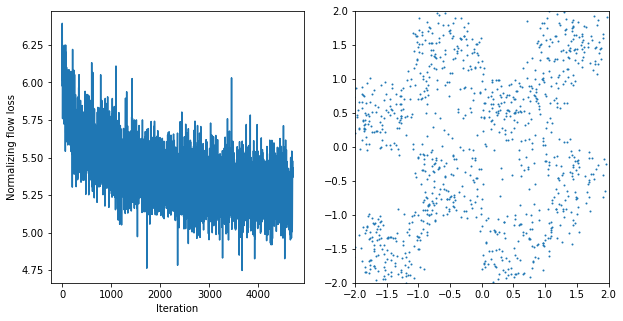

In [67]:
train_nf(trainloader_4d, nf, opt, num_epochs=30, verbose_num_iters=100, data_type='2d')

## Генерируем MNIST.

RealNVP слои настолько мощные, что могут научиться генерировать распределение над реальными данными - например над картинками.

In [12]:
import torch
from torchvision.datasets import MNIST
import torchvision.transforms as transforms


transform = transforms.Compose([
                transforms.Resize(16),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...



Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [68]:
prior = torch.distributions.MultivariateNormal(torch.zeros(16 * 16).cuda(), torch.eye(16 * 16).cuda())

layers = []
for i in range(32):
  layers.append(RealNVP(var_size=16 * 16, mask=torch.randint(0, 2, (16 * 16, )).cuda()))
  layers.append(ActNorm(var_size=16 * 16))

nf = NormalizingFlow(layers=layers,
                     prior=prior)
nf.cuda()
opt = torch.optim.Adam(nf.parameters(), lr=3e-4)

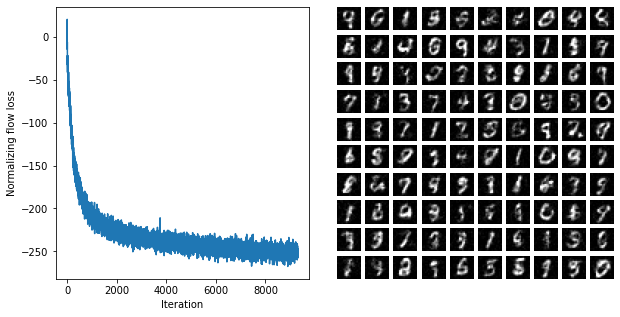

In [69]:
train_nf(trainloader_mnist, nf, opt, num_epochs=10, verbose_num_iters=100, data_type='mnist')

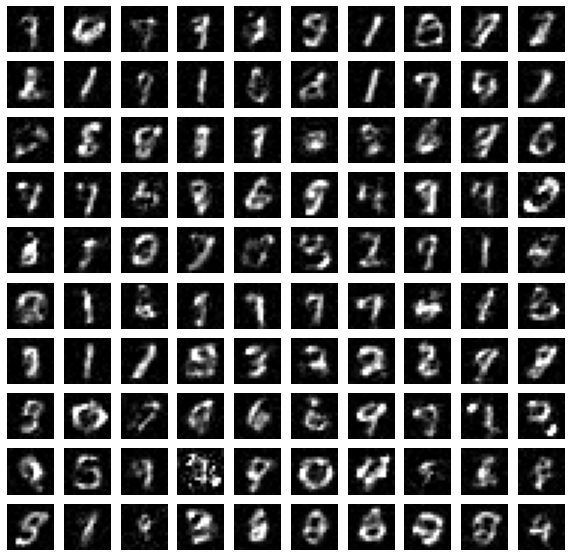

In [70]:
with torch.no_grad():
  sampled_mnist = torch.clamp(nf.sample(100), min=-1., max=1.)

plt.figure(figsize=(10, 10))

for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i].view(16, 16).detach().cpu().numpy(), cmap='gray')

Несмотря на то, что нормпоток получился довольно тяжелым (параметризуется большим числом параметров), он довольно быстро (по сравнению с GAN) подхватывает закономерности в данных.

Построенная на обратимых свертках модель под названием GLOW может моделировать даже человеческие лица.

![Normalizing flows](https://raw.githubusercontent.com/rosinality/glow-pytorch/master/sample.png)

Image credits: [rosinality/glow-pytorch](https://github.com/rosinality/glow-pytorch)

## NF прайор для VAE.

На практике часто нормпотоки любят использовать как подчасть какой-то большой генеративной модели.

Например, как обучаемый прайор (вместо необучаемого нормального распределения) в VAE. Благодаря этому, латентный код получается куда более информативным, так как никто его не заставляет быть похожим на гауссиану - прайор сам подстраивается под данные.

Для этого, KL дивергенцию представляют как энтропию гауссины, выдаваемой энкодером, минус вероятность семпла латентного кода в прайоре.

$$ KL_{enc, prior} = H(q_{enc}(z|x)) - \mathbb{E}_{z \sim q_{enc}(z|x) } p_{prior}(z) $$

In [71]:
class MNISTEncoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTEncoder_vae, self).__init__()
        self.lat_size = lat_size

        self.enc_net = nn.Sequential(
            nn.Flatten(), 
            nn.Linear(784, 256), nn.ReLU(),
            nn.Linear(256, 128), nn.ReLU(),
            nn.Linear(128, 64), nn.ReLU())

        self.mu = nn.Linear(64, self.lat_size)
        self.log_sigma = nn.Linear(64, self.lat_size)
        
    def forward(self, x):
        
        z = self.enc_net(x)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        
        return mu, log_sigma 
    
class MNISTDecoder_vae(nn.Module):
    def __init__(self, lat_size):
        super(MNISTDecoder_vae, self).__init__()
        self.lat_size = lat_size
        
        self.dec_net = nn.Sequential(
            nn.Linear(self.lat_size, 128), nn.ReLU(),
            nn.Linear(128, 256), nn.ReLU(),
            nn.Linear(256, 784), nn.Sigmoid())
        
    def forward(self, z):

        x_rec = self.dec_net(z)
        x_rec = x_rec.view(-1, 1, 28, 28)
        
        return x_rec

In [42]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, lat_size,
                 prior='normal', 
                 KL_weight=0.001,
                 encoder_class=MNISTEncoder_vae, 
                 decoder_class=MNISTDecoder_vae,
                 criterion_class=nn.MSELoss):
        super(VariationalAutoEncoder, self).__init__()
        
        self.lat_size = lat_size
        self.enc = encoder_class(lat_size)
        self.dec = decoder_class(lat_size)
        
        self.criterion = criterion_class()

        # теперь можем использовать норм потоки в качестве прайора!
        if prior == 'normal':
          self.prior = torch.distributions.MultivariateNormal(torch.zeros(lat_size).cuda(), torch.eye(lat_size).cuda())
        elif prior == 'nf':
          prior = torch.distributions.MultivariateNormal(torch.zeros(lat_size).cuda(), torch.eye(lat_size).cuda())
          layers = []
          for i in range(16):
            layers.append(RealNVP(var_size=lat_size, mask=((torch.arange(2) + i) % 2).cuda()))
            layers.append(ActNorm(var_size=lat_size))

          self.prior = = NormalizingFlow(layers=layers,
                                       prior=prior)

        self.k = 0
        self.KL_weight = KL_weight
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(device)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, z, mu, log_sigma):
        # оценка KL по Монте Карло
        h = -self.lat_size * np.log(2 * np.pi) / 2
        h = h - ((z - mu) ** 2 / (torch.exp(log_sigma) + 1e-2) + log_sigma).sum(dim=1) / 2

        p_z = self.prior.log_prob(z)

        KL = torch.mean(h - p_z)
   
        recon_loss = self.criterion(x, rec_x)
        
        return KL*self.KL_weight + recon_loss
    
    def compute_loss(self, x, return_rec=False):
        
        mu, log_sigma = self.encode(x)
        z = self.sample_z(mu, log_sigma)
        rec_x = self.decode(z)
        
        loss = self.custom_loss(x, rec_x, z, mu, log_sigma)
        
        if return_rec:
            return loss, rec_x
        else:
            return loss

In [43]:
def train_vae(model, tr_dataloader, optimizer, num_epochs=5, verbose_num_iters=32):
    model.train()
    loss_trace = []
    
    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for iter_i, batch in enumerate(tr_dataloader):
            x, _ = batch
            x = x.to(device)
            
            optimizer.zero_grad() # Зануляем градиенты
            
            loss, rec_x = model.compute_loss(x, return_rec=True)
            
            loss.backward() # Считаем градиенты
            optimizer.step() # Обновляем параметры модели
            
            loss_trace.append(loss.item())
        
            if (iter_i + 1) % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 2, 1)
                plt.xlabel('Iteration')
                plt.ylabel('L2 loss (x, x_rec)')
                plt.plot(loss_trace)
                
                for i in range(3):
                    plt.subplot(2, 6, 4 + i)
                    plt.axis('off')
                    plt.imshow(x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                    plt.subplot(2, 6, 10 + i)
                    plt.axis('off')
                    plt.imshow(rec_x[i, 0].cpu().detach().numpy(), cmap='gray')
                    
                plt.show()
                
    model.eval()

def get_latent_codes_and_labels_vae(dataloader, model, num_objects):
    lat_codes = torch.empty((0, model.lat_size)).to(device)
    labels = torch.empty((0)).to(device)

    for batch in dataloader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        cur_lat_mean, cur_lat_var = model.encode(x)
        
        eps = torch.randn(cur_lat_mean.shape).to(device)
        cur_lat_codes = cur_lat_mean + torch.exp(cur_lat_var / 2) * eps
        
        lat_codes = torch.cat((lat_codes, cur_lat_codes), dim=0)
        labels = torch.cat((labels, y), dim=0)
    
        if lat_codes.shape[0] >= num_objects:
            break
    lat_codes = lat_codes[:num_objects].detach().cpu().numpy()
    labels = labels[:num_objects].detach().cpu().numpy()

    return lat_codes, labels

In [44]:
transform = transforms.Compose([transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./mnist', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.MNIST(root='./mnist', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=1)

Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw




Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw


Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw
Processing...
Done!


Обучим модель с латентным кодом длины 2 и нормальным прайором и визуализируем латентный код.

In [45]:
model = VariationalAutoEncoder(2, prior='normal')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

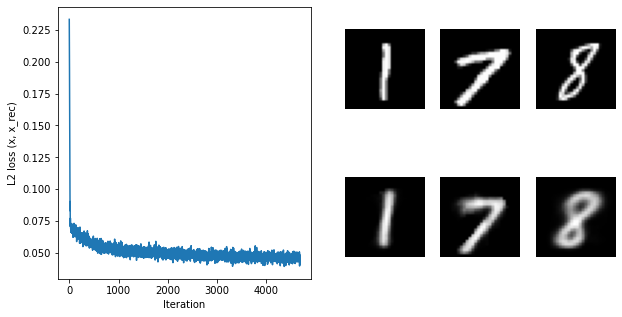

In [46]:
train_vae(model, train_dataloader, optimizer)

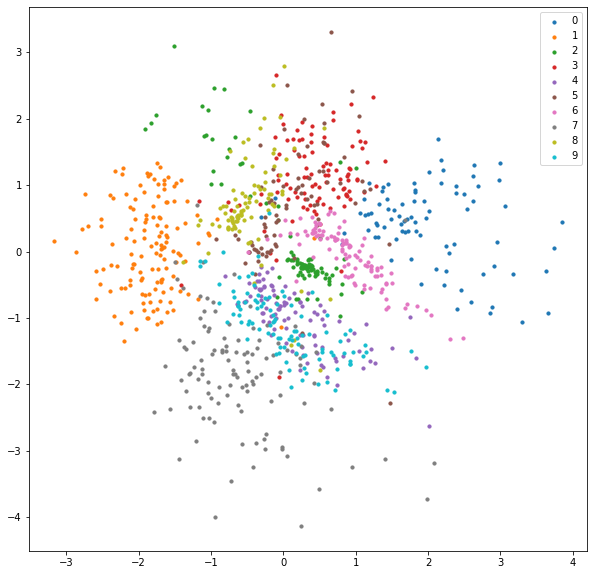

In [47]:
# визуализируем получившееся латентное пр-во

lat_codes, labels = get_latent_codes_and_labels_vae(train_dataloader, model, 1000)

plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}', s=10)
    
plt.legend()
plt.show()

Теперь обучим модель с латентным кодом длины 2 и обучаемым прайором на нормпотоках и визуализируем латентный код.

In [48]:
model = VariationalAutoEncoder(2, prior='nf')
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

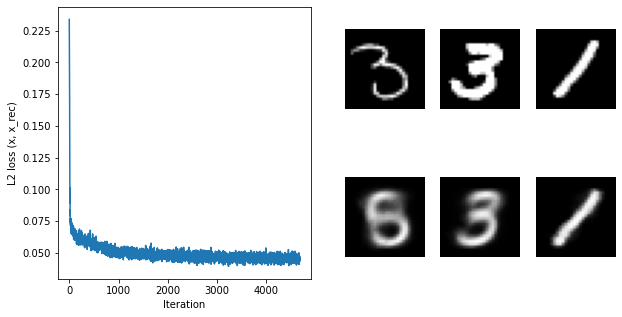

In [49]:
train_vae(model, train_dataloader, optimizer)

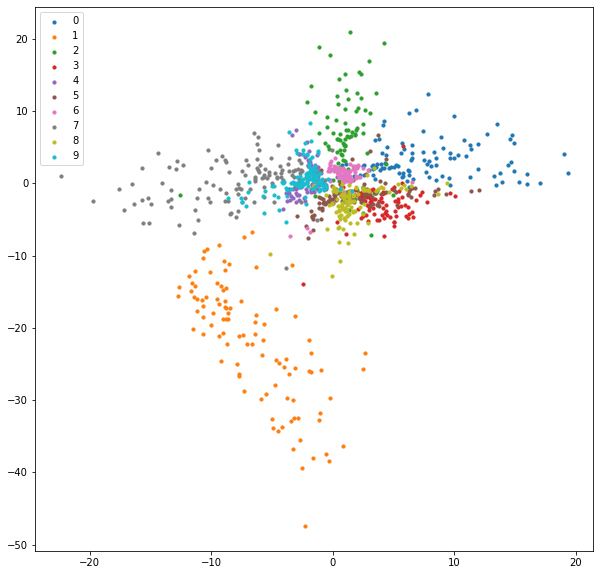

In [51]:
# визуализируем получившееся латентное пр-во

lat_codes, labels = get_latent_codes_and_labels_vae(train_dataloader, model, 1000)

plt.figure(figsize=(10, 10))

for cl in range(10):
    lat_codes_class = lat_codes[labels == cl]
    plt.scatter(lat_codes_class[:, 0], lat_codes_class[:, 1], label=f'{cl}', s=10)
    
plt.legend()
plt.show()

Латентное пространство теперь не ограничено рамками нормального распределения и может обучаться как ему удобно. Благодаря этому классы становятся лучше разделимыми даже в 2d случае.